# EchoNext-Mini summary and results

In [1]:
from matplotlib.font_manager import FontProperties
import matplotlib.patches
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import sklearn.metrics

from collections import defaultdict

from constants import *

%matplotlib inline 

In [ ]:
dataset_metadata_path = '/path/to/EchoNext_metadata_100k.csv'
model_preds_path = '/path/to/logits.npy'

In [ ]:
dataset_metadata = pd.read_csv(dataset_metadata_path)

# LVWT is the maximum of non-NaN IVS and LVPW
dataset_metadata['lvwt_measurement'] = np.maximum(
    dataset_metadata['ivs_measurement'].fillna(-1),
    dataset_metadata['lvpw_measurement'].fillna(-1)
).replace(-1, np.nan)

# Binary sex converted to boolean
dataset_metadata['sex'] = (dataset_metadata['sex'] == 'male').astype(int)

# QT Interval computed using Bazett's Formula
dataset_metadata['qt_interval'] = dataset_metadata['qt_corrected'] * (60 / dataset_metadata['ventricular_rate']) ** .5



## Dataset summary

### Data missingness

In [4]:
missingness = pd.DataFrame(
    {
        'count': dataset_metadata.isna().sum(),
        'frac': dataset_metadata.isna().mean(),
    }
)
missingness = missingness.rename(index=NAMES)
missingness = missingness.apply(lambda row: f'{int(row["count"])} ({row["frac"] * 100:.1f}%)', axis=1)

print(missingness.to_csv())

,0
ecg_key,0 (0.0%)
patient_key,0 (0.0%)
Age,0 (0.0%)
Male,0 (0.0%)
Year,0 (0.0%)
Ventricular Rate,0 (0.0%)
Atrial Rate,613 (0.6%)
PR Interval,10369 (10.4%)
QRS Duration,0 (0.0%)
QTc,1 (0.0%)
LVEF $\leq$ 45,0 (0.0%)
LVWT $\geq$ 1.3,0 (0.0%)
Moderate or Greater Aortic Stenosis,0 (0.0%)
Moderate or Greater Aortic Regurgitation,0 (0.0%)
Moderate or Greater Mitral Regurgitation,0 (0.0%)
Moderate or Greater Tricuspid Regurgitation,0 (0.0%)
Moderate or Greater Pulmonary Regurgitation,0 (0.0%)
Moderate or Greater RV Systolic Dysfunction,0 (0.0%)
Moderate or Greater Pericardial Effusion,0 (0.0%)
PASP $\geq$ 45,0 (0.0%)
TR Max V $\geq$ 3.2,0 (0.0%)
Moderate or Greater Structural Heart Disease,0 (0.0%)
Aortic Stenosis Value,9003 (9.0%)
Aortic Regurgitation Value,9003 (9.0%)
Mitral Regurgitation Value,9000 (9.0%)
Tricuspid Regurgitation Value,9036 (9.0%)
Pulmonary Regurgitation Value,8944 (8.9%)
RV Systolic Function Value,9096 (9.1%)
Pericardial Effusion Value,11823 (11.8%)
Intraventricular Septu

### Data summary table

In [5]:
def table1(df, numeric_cols, bool_cols, cat_cols):
    n_samples = pd.Series([df.shape[0], df['patient_key'].nunique()], index=['N samples', 'N patients'])

    def fmt(x):
        if x.name in FORMAT_AS_FLOAT:
            return '.1f'
        else:
            return '.0f'

    numeric_stats = df[numeric_cols].apply(
        lambda x: f'{x.quantile(0.5):{fmt(x)}} [{x.quantile(0.25):{fmt(x)}}, {x.quantile(0.75):{fmt(x)}}]')
    bool_stats = df[bool_cols].apply(
        lambda x: f'{x.sum():.0f} ({x.mean() * 100:.1f}%)')

    cat_stats_metadata = [
        pd.concat(
            [
                df[col].value_counts(),
                df[col].value_counts() / len(df) * 100
            ],
            axis=1,
            keys=['value', 'pct']
        ).sort_values('value', ascending=False)
        for col in METADATA_CAT_COLS
    ]
    cat_stats_raw = [
        pd.concat(
            [
                df[col].value_counts(),
                df[col].value_counts() / len(df) * 100
            ],
            axis=1,
            keys=['value', 'pct']
        ).sort_index(key=(lambda idx: [CUSTOM_ORDER.index(x) for x in idx]))
        for col in RAW_ECHO_CATEGORICAL
    ]

    cat_stats = pd.concat(cat_stats_metadata, keys=cat_cols)
    cat_stats = cat_stats.apply(lambda x: f'{x.value:.0f} ({x.pct:.1f}%)', axis=1)

    return pd.concat([n_samples, bool_stats, numeric_stats, cat_stats])

In [6]:
metadata_summary = table1(dataset_metadata, NUMERIC_COLS, BOOL_COLS, CAT_COLS)
metadata_first_ecg_summary = table1(dataset_metadata[dataset_metadata['most_recent_ecg']], NUMERIC_COLS, BOOL_COLS, CAT_COLS)
split_summary = pd.DataFrame({
    split: table1(dataset_metadata[dataset_metadata['split'] == split], NUMERIC_COLS, BOOL_COLS, CAT_COLS)
    for split in ['train', 'val', 'test']
})

metadata_summary = pd.concat(
    [metadata_summary, metadata_first_ecg_summary, split_summary],
    axis=1,
)
metadata_summary.columns=['All ECGs', 'Latest ECG', 'Train', 'Valid', 'Test']

metadata_summary = metadata_summary.rename(lambda l: f'{get_name(l[0])}: {get_name(l[1])}' if type(l) is tuple else l)
metadata_summary = metadata_summary.rename(NAMES)

metadata_summary.index = [i.replace('$\geq$', '≥').replace('$\leq$', '≤') for i in metadata_summary.index]

for idx in list(metadata_summary.index):
    if (metadata_summary.loc[idx] == '0 (0.0%)').all():
        metadata_summary.drop(idx, inplace=True)

print(metadata_summary.to_csv())

,All ECGs,Latest ECG,Train,Valid,Test
N samples,100000,36286,72475,4626,5442
N patients,36286,36286,26218,4626,5442
Male,53581 (53.6%),17953 (49.5%),38951 (53.7%),2270 (49.1%),2711 (49.8%)
LVEF ≤ 45,23892 (23.9%),6535 (18.0%),16962 (23.4%),866 (18.7%),962 (17.7%)
LVWT ≥ 1.3,24220 (24.2%),6828 (18.8%),17667 (24.4%),877 (19.0%),1061 (19.5%)
Moderate or Greater Aortic Stenosis,4054 (4.1%),1973 (5.4%),2919 (4.0%),252 (5.4%),286 (5.3%)
Moderate or Greater Aortic Regurgitation,1264 (1.3%),433 (1.2%),878 (1.2%),62 (1.3%),66 (1.2%)
Moderate or Greater Mitral Regurgitation,8451 (8.5%),2352 (6.5%),6137 (8.5%),282 (6.1%),337 (6.2%)
Moderate or Greater Tricuspid Regurgitation,10651 (10.7%),2534 (7.0%),7707 (10.6%),305 (6.6%),353 (6.5%)
Moderate or Greater Pulmonary Regurgitation,821 (0.8%),156 (0.4%),603 (0.8%),21 (0.5%),20 (0.4%)
Moderate or Greater RV Systolic Dysfunction,13243 (13.2%),2899 (8.0%),9597 (13.2%),368 (8.0%),419 (7.7%)
Moderate or Greater Pericardial Effusion,3023 (3.0%),475 (1.3%),

### Data summary figures

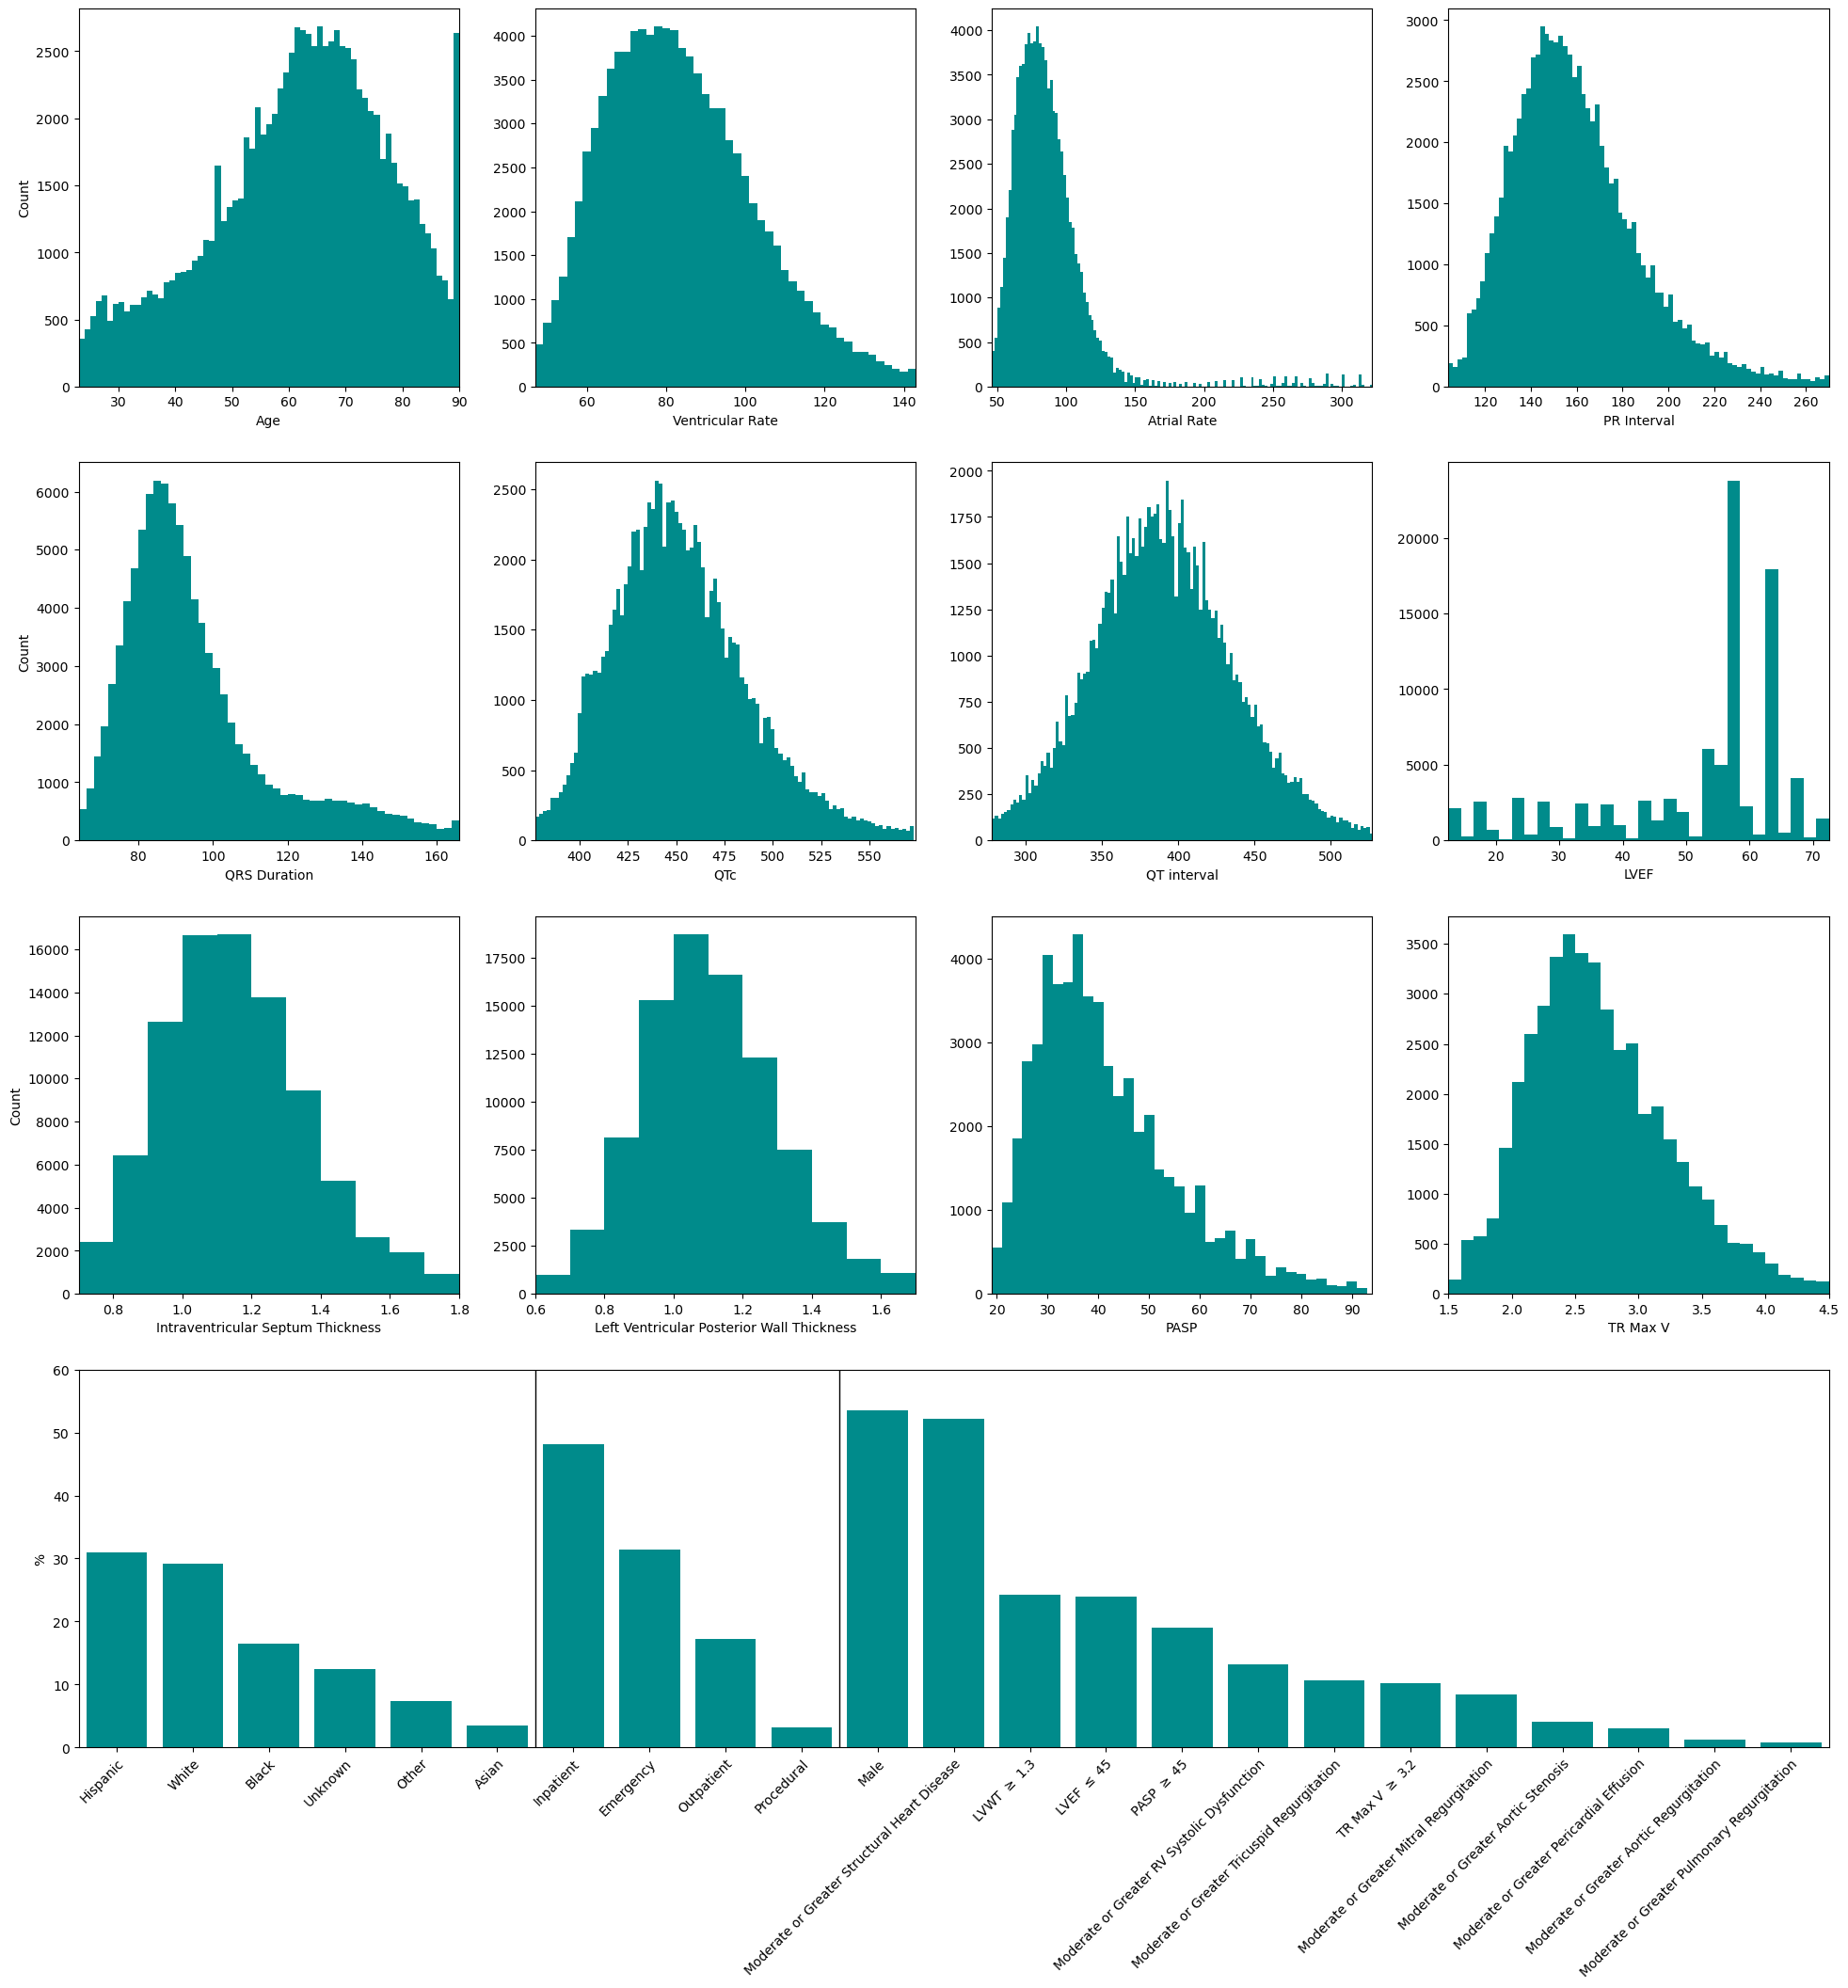

In [7]:
color = 'darkcyan'

bin_widths = defaultdict(lambda: 2)
bin_widths.update({
    'age_at_ecg': 1,
    'ivs_measurement': .1,
    'lvpw_measurement': .1,
    'lvwt_measurement': .1,
    'tr_max_velocity_value': .1,
})


fig, axes = plt.subplots(4, 4, figsize=(24, 24))

hist_axes = axes.flatten()
for i, column in enumerate(HIST_COLS):
    x_min = np.percentile(dataset_metadata[column].dropna(), 1)
    x_max = np.percentile(dataset_metadata[column].dropna(), 99)

    hist_axes[i].hist(
        dataset_metadata[column],
        bins=np.arange(
            x_min,
            x_max + 1,
            bin_widths[column]
        ),
        color=color,
    )
    hist_axes[i].set_xlim(x_min, x_max)
    hist_axes[i].set_xlabel(NAMES[column])
    if i % 4 == 0:
        hist_axes[i].set_ylabel('Count')
    # plt.show()


gs = axes[3, 2].get_gridspec()
# remove the underlying Axes
bar_ax = fig.add_subplot(gs[3, :])

for ax in axes[3:].flatten():
    ax.remove()

def value_counts(key):
    counts = {}
    for value in dataset_metadata[key].unique():
        counts[value] = (dataset_metadata[key] == value).mean()
    return pd.Series(counts).sort_values(ascending=False)

proportions = dataset_metadata[BOOL_COLS].mean().sort_values(ascending=False)
races = value_counts('race_ethnicity')
locations = value_counts('location_setting')

proportions = pd.concat([races, locations, proportions])

bar_ax.bar(range(len(proportions)), proportions, color=color)

bar_ax.set_ylim(0, .6)
bar_ax.set_yticks(np.arange(0, .61, .1), labels=np.arange(0, 61, 10))
bar_ax.set_ylabel('%')

bar_ax.set_xlim(-.5, len(proportions) - .5)
bar_ax.set_xticks(range(len(proportions)), labels=[NAMES[c] for c in proportions.index],
              rotation=90, ha="right", rotation_mode="anchor")


bar_ax.plot([len(races) - .5, len(races) - .5], [0, 1], c='black', linewidth=1)
bar_ax.plot([len(races) + len(locations) - .5, len(races) + len(locations) - .5], [0, 1], c='black', linewidth=1)

bar_ax.set_xticklabels([NAMES[c] for c in proportions.index], rotation=45, ha='right');


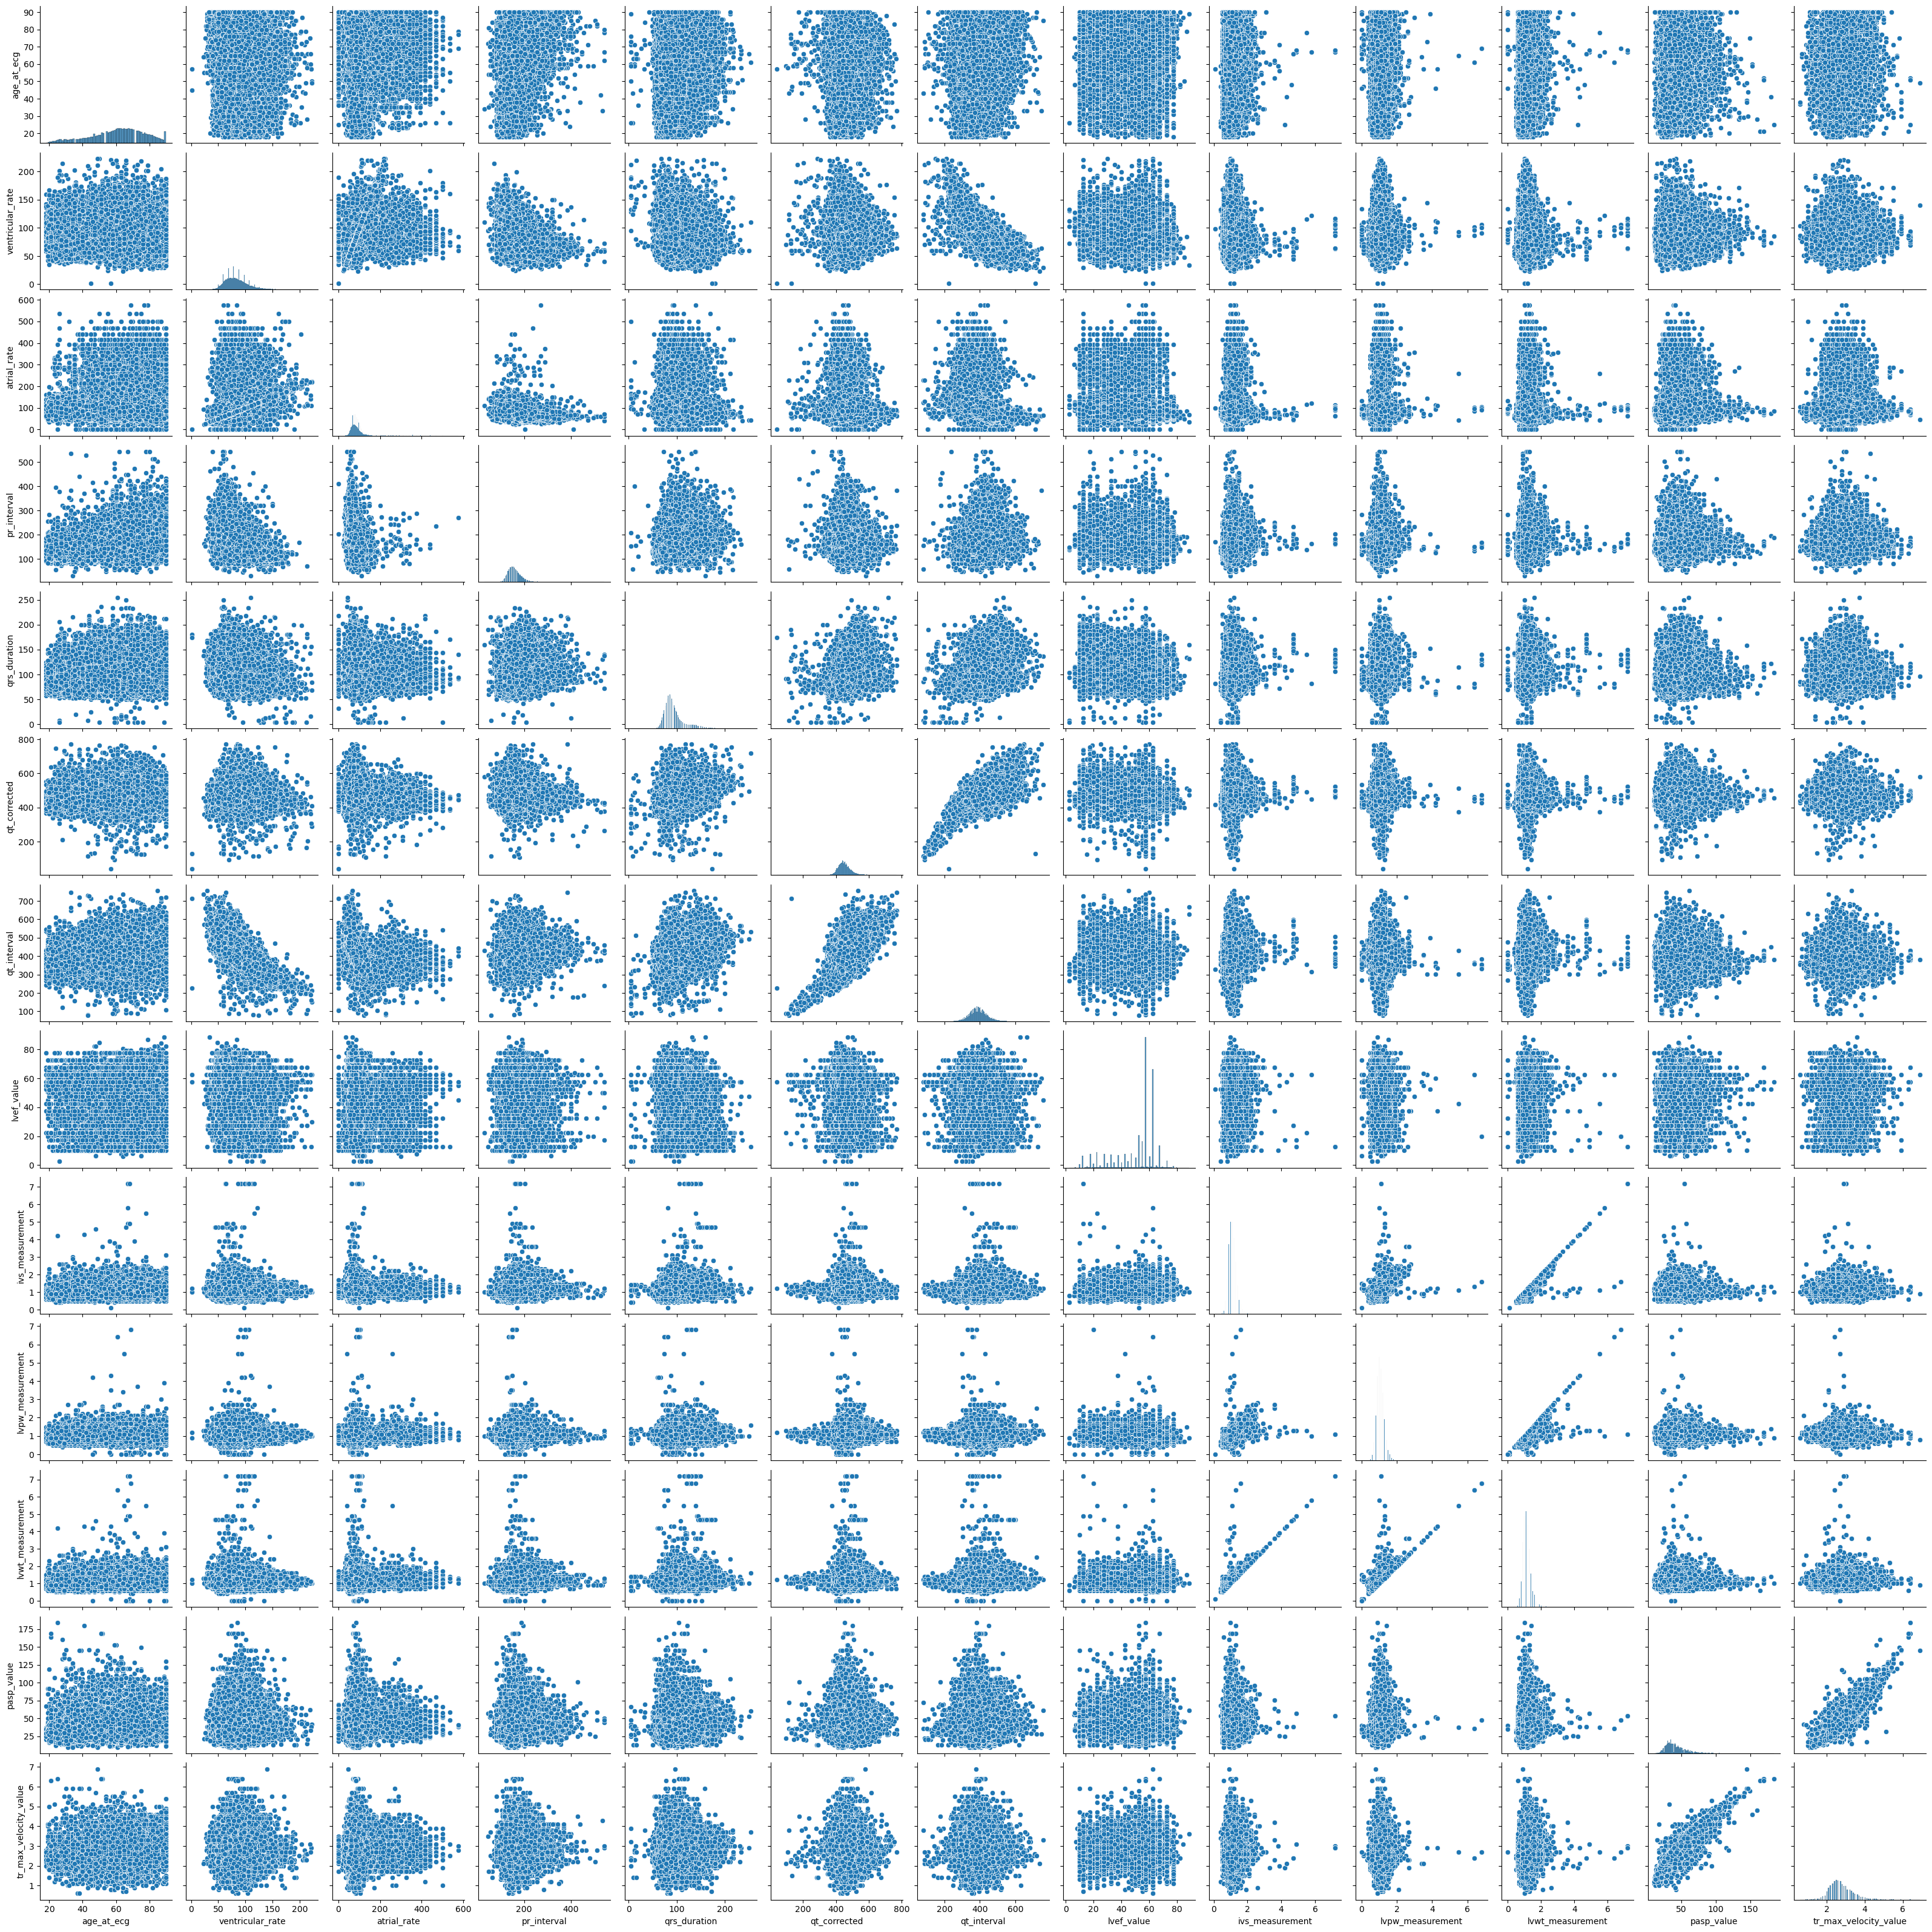

In [8]:
sns.pairplot(dataset_metadata[NUMERIC_COLS]);

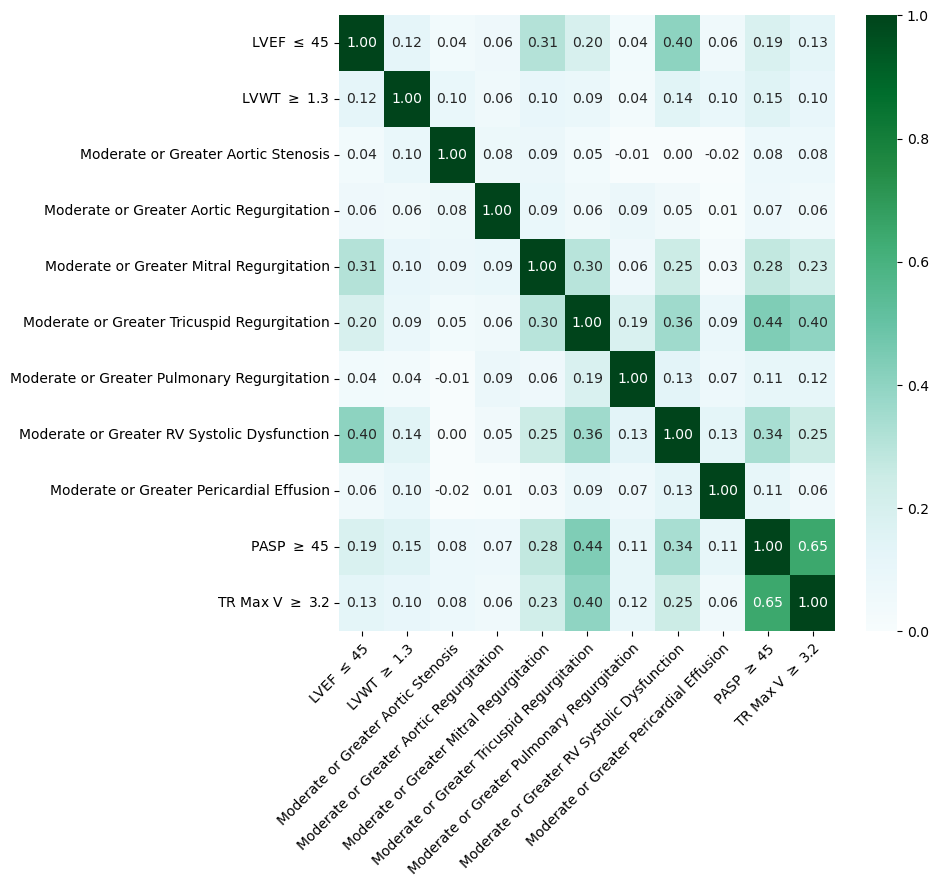

In [9]:
df = pd.DataFrame(dataset_metadata, columns=SHD_MODERATE_OR_GREATER_COLS[:-1]).rename(NAMES, axis=1)

sns.heatmap(df.corr(), annot=True, mask=False, cmap='BuGn', vmin=0, vmax=1, fmt='.2f')
plt.gcf().set_size_inches(8, 8)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor");

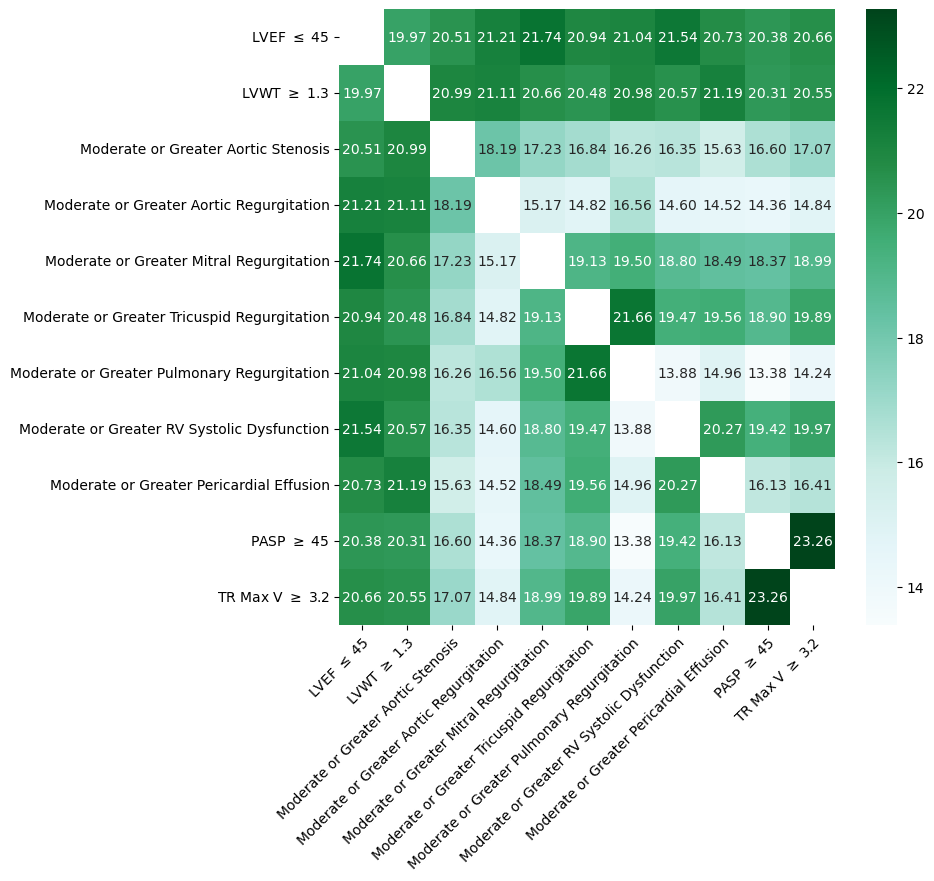

In [10]:
def log_odds_ratio(arr1, arr2):
    arr1, arr2 = arr1.astype(bool), arr2.astype(bool)
    return np.log(
        (arr1 * arr2).sum() * (~arr1 * ~arr2).sum() / 
        (~arr1 * arr2).sum() * (arr1 * ~arr2).sum()
    )

corr = df.corr(log_odds_ratio)
for i in range(len(corr)):
    corr.iloc[i, i] = np.nan


sns.heatmap(corr, annot=True, mask=False, cmap='BuGn', fmt='.2f')
plt.gcf().set_size_inches(8, 8)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor");

# Model performance

In [11]:
test_predictions = pd.DataFrame(
    np.load(model_preds_path),
    columns=[col + '_yh' for col in SHD_MODERATE_OR_GREATER_COLS]
)

test_metadata = dataset_metadata.loc[
    dataset_metadata['split'] == 'test',
    SHD_MODERATE_OR_GREATER_COLS + ['ecg_key', 'race_ethnicity', 'sex', 'location_setting']
].reset_index()

test_data = pd.concat([test_metadata, test_predictions], axis=1)

In [12]:
def bootstrap_score(y_true, y_pred, prc=False, n=1000, base_fn=None):
    
    if base_fn is None:
        base_fn = sklearn.metrics.average_precision_score if prc else sklearn.metrics.roc_auc_score
    fn = lambda a, b: base_fn(a, b) * 100
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    score = fn(y_true, y_pred)
    bootstrap_scores = []
    rng = np.random.default_rng(0)
    for _ in range(n):
        idx = rng.choice(len(y_true), len(y_true))
        bootstrap_scores.append(fn(y_true[idx], y_pred[idx]))

    lower = np.percentile(bootstrap_scores, 2.5)
    upper = np.percentile(bootstrap_scores, 97.5)
    return score, lower, upper, f'{score:4.1f} ({lower:4.1f}-{upper:4.1f})'


def plot_curve(data, prc=False, labels=SHD_MODERATE_OR_GREATER_COLS, emph='shd_moderate_or_greater_flag', n=1000):

    legend_data = []

    for label in labels:
        y_true, y_pred = data[label], data[label + '_yh']

        if label == emph:
            c = 'black'
            alpha = 1
        else:
            c = None
            alpha = .6

        if prc:
            y, x, _ = sklearn.metrics.precision_recall_curve(y_true, y_pred)
            score = bootstrap_score(y_true, y_pred, prc=True, n=n)[-1]
            name = 'AUPRC'
        else:
            x, y, _ = sklearn.metrics.roc_curve(y_true, y_pred)
            score = bootstrap_score(y_true, y_pred, prc=False, n=n)[-1]
            name = 'AUROC'

        artist, = plt.plot(x, y, lw=2, 
            label=f'{NAMES[label]} ({name} = {score})', c=c, alpha=alpha)
        
        legend_data.append((artist, NAMES[label], name, score))

    plt.gca().set_aspect('equal')

    if prc:
        plt.xlabel('Recall')
        plt.ylabel('Precision')
    else:
        plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

    plt.xlim([0, 1])
    plt.ylim([0, 1])

    return legend_data


def plot_comp(n=1000):

    aurocs = {}
    auprcs = {}

    for category in ['race_ethnicity', 'sex', 'location_setting']:
        for value in test_data[category].unique():
            for label in ['shd_moderate_or_greater_flag']:
                tbl = test_data[test_data[category] == value]
                if category == 'sex':
                    name = 'Male' if value else 'Female'
                else:
                    name = NAMES[value]
                name = f'{NAMES[category]}: {name}'
                aurocs[name] = bootstrap_score(
                    y_true=tbl['shd_moderate_or_greater_flag'],
                    y_pred=tbl['shd_moderate_or_greater_flag_yh'],
                    n=n,
                )
                auprcs[name] = bootstrap_score(
                    y_true=tbl['shd_moderate_or_greater_flag'],
                    y_pred=tbl['shd_moderate_or_greater_flag_yh'],
                    prc=True,
                    n=n,
                )

    full_pop = bootstrap_score(
        test_data['shd_moderate_or_greater_flag'],
        test_data['shd_moderate_or_greater_flag_yh'],
        n=n,
    )

    print('AUROC')
    print(aurocs)
    print('AUPRC')
    print(auprcs)

    c = 'blue'

    plt.plot([full_pop[0], full_pop[0]], [-2, 12], c=c, zorder=-1000)
    plt.plot([full_pop[1], full_pop[1]], [-2, 12], c=c, zorder=-1000, alpha=.2)
    plt.plot([full_pop[2], full_pop[2]], [-2, 12], c=c, zorder=-1000, alpha=.2)
    rect = matplotlib.patches.Rectangle((full_pop[1], -2), full_pop[2] - full_pop[1], 14, linewidth=1, edgecolor=c, facecolor=c, alpha=0.2)
    plt.gca().add_patch(rect)

    for i, (label, ci) in enumerate(aurocs.items()):
        plt.scatter([ci[0]], [i], c='black', marker='D')
        plt.plot(ci[1:3], [i, i], c='black')


    plt.scatter([full_pop[0]], [-1], c='black', marker='D')
    plt.plot(full_pop[1:3], [-1, -1], c='black')

    for cut in [-.5, 5.5, 7.5]:
        plt.plot([50, 100], [cut, cut], c='black', alpha=.4)

    ticks = ['Full population'] + list(aurocs.keys())
    d = {
        'Male: Male': 'Sex: Male',
        'Male: Female': 'Sex: Female'
        }
    ticks = [d[t] if t in d else t for t in ticks]
    plt.yticks(np.arange(-1, 12), ticks)

    plt.xlim([70, 90])
    plt.ylim(11.5, -1.5)
    plt.xlabel('AUROC')


def add_table_legend(ax, handles, extra_cols, headers=None, loc="upper right", family="DejaVu Sans Mono", **legend_kwargs):

    cols = list(zip(*extra_cols))  # shape: 3 x N
    widths = []
    for i in range(3):
        items = list(cols[i])
        if headers:
            items.append(str(headers[i]))
        widths.append(max(len(str(s)) for s in items))

    def fmt_row(row):
        return "  ".join(str(s).rjust(w) for s, w in zip(row, widths))

    ax.legend(
        handles,
        [fmt_row(row) for row in extra_cols],
        title=fmt_row([str(h) for h in headers]),
        loc=loc,
        handlelength=2.2,
        handletextpad=1.0,
        borderpad=0.8,
        prop=FontProperties(family=family),
        title_fontproperties=FontProperties(family=family),
        **legend_kwargs
    )

def sensitivity(y, yh):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y, yh).ravel()
    return tp / (tp + fn)

def specificity(y, yh):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y, yh).ravel()
    return tn / (tn + fp)

def ppv(y, yh):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y, yh).ravel()
    return tp / (tp + fp)

def npv(y, yh):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y, yh).ravel()
    return tn / (tn + fn)

AUROC
{'Race/Ethnicity: White': (80.40883044372612, 78.31545294734825, 82.50452331887902, '80.4 (78.3-82.5)'), 'Race/Ethnicity: Unknown': (83.31011707787752, 80.42916472925727, 86.13740919954135, '83.3 (80.4-86.1)'), 'Race/Ethnicity: Black': (81.74519190392205, 78.83343448715796, 84.51040079601806, '81.7 (78.8-84.5)'), 'Race/Ethnicity: Other': (81.49610894941634, 77.81366308244507, 85.25198075999458, '81.5 (77.8-85.3)'), 'Race/Ethnicity: Asian': (81.34251290877796, 74.30636332535069, 87.86311673060314, '81.3 (74.3-87.9)'), 'Race/Ethnicity: Hispanic': (82.68754506410858, 80.672962292437, 84.75413613030597, '82.7 (80.7-84.8)'), 'Male: Male': (81.28577949319624, 79.51026678511434, 82.85551811985377, '81.3 (79.5-82.9)'), 'Male: Female': (81.9161763092399, 80.27903184766865, 83.5786180939455, '81.9 (80.3-83.6)'), 'ECG Setting: Inpatient': (79.69838027913002, 77.78442293206318, 81.48845537207959, '79.7 (77.8-81.5)'), 'ECG Setting: Outpatient': (79.48845224492854, 76.21867103655896, 82.608853

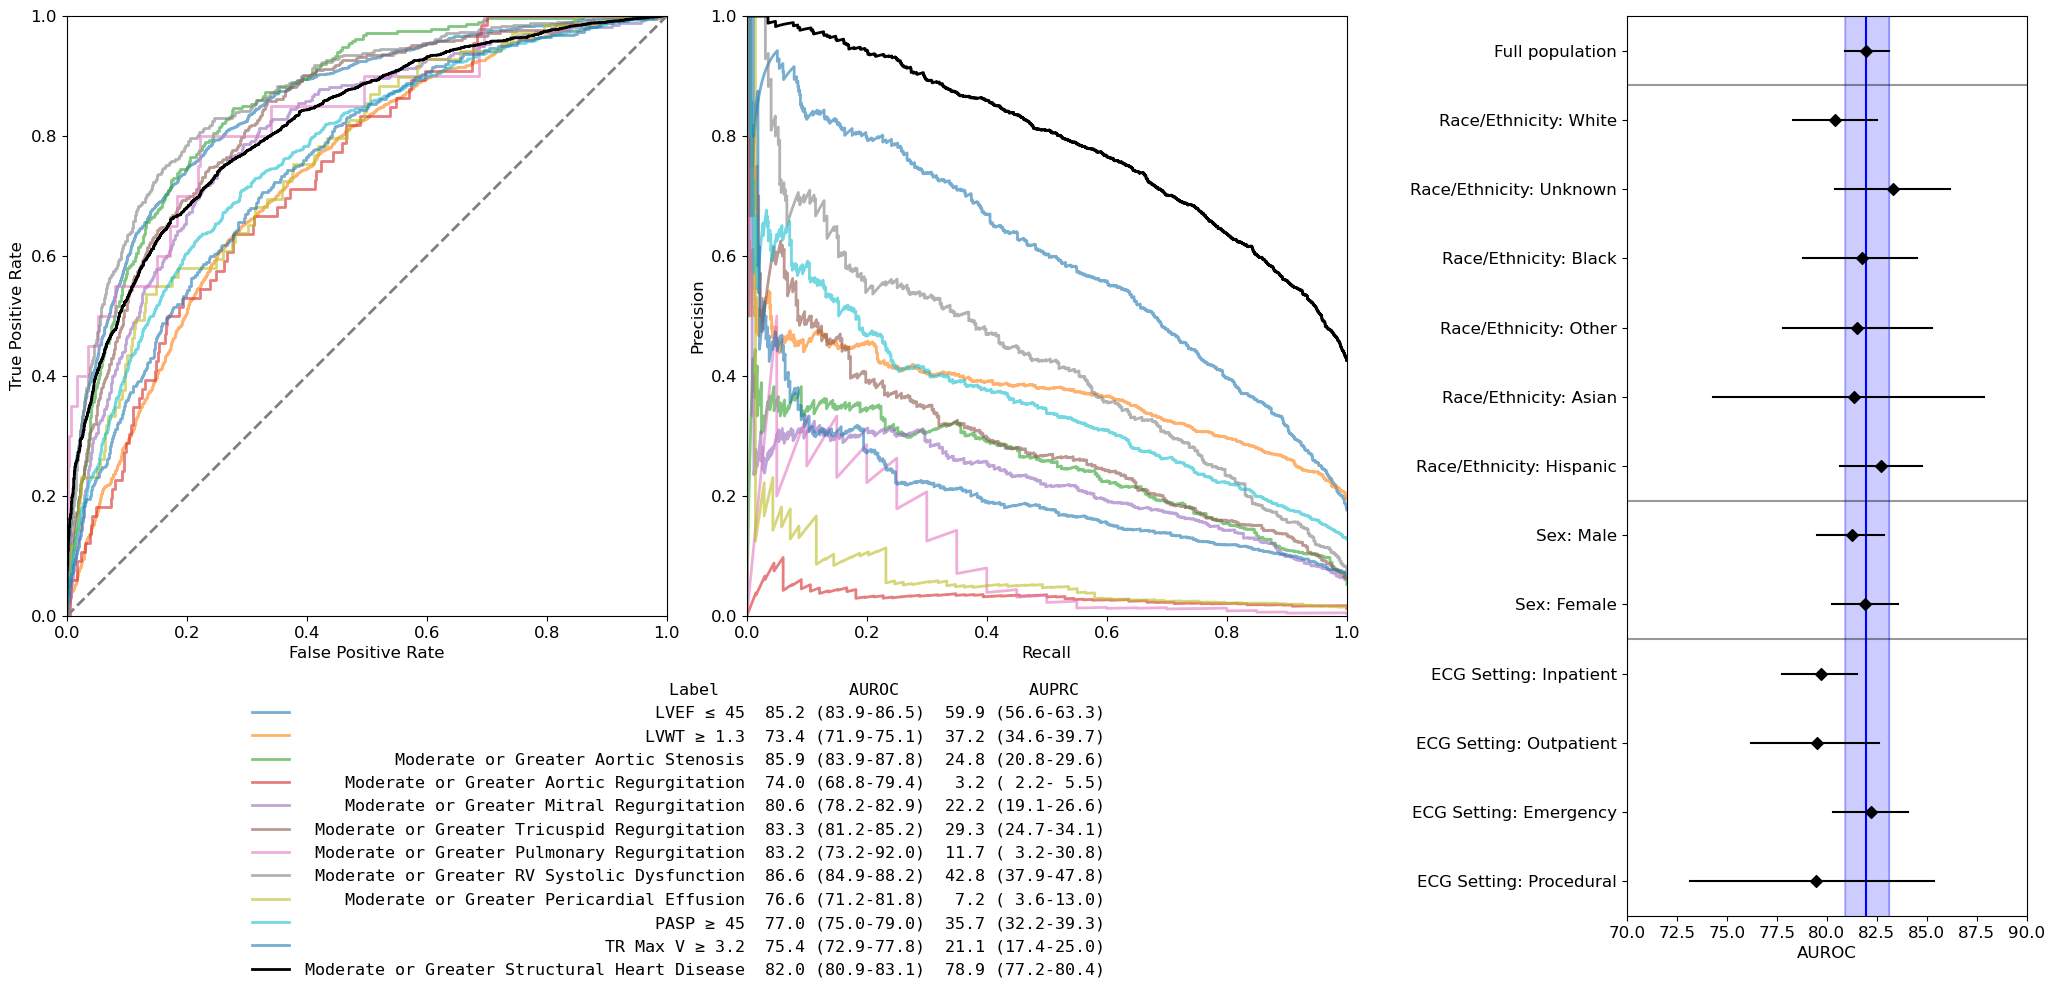

In [13]:
import matplotlib.pyplot as plt

n = 1000

plt.rcParams["font.size"] = 12

fig = plt.figure(figsize=(20, 9))

gap = 0.04 

ax1 = fig.add_axes([0/20, (9-6)/9, 6/20, 6/9])
auc_legend_data = plot_curve(test_data, n=n)

ax2 = fig.add_axes([ (6/20) + gap, (9-6)/9, 6/20, 6/9])
prc_legend_data = plot_curve(test_data, prc=True, n=n)

ax3 = fig.add_axes([ (12/20) + 2*gap + 2 / 20, 0, 4/20, 9/9])
plot_comp(n=n)

artists = [a[0] for a in  auc_legend_data]
table_data = [(a[1].replace('$\geq$', '≥').replace('$\leq$', '≤'), a[3], p[3]) for a, p in zip(auc_legend_data, prc_legend_data)]

add_table_legend(ax1, artists, table_data, family='DejaVu Sans Mono', headers=['Label', 'AUROC', 'AUPRC'], bbox_to_anchor=[1 + gap / 2, -.075], loc='upper center', frameon=False)

plt.show()


In [14]:
roc = pd.DataFrame(
    sklearn.metrics.roc_curve(
        test_data['shd_moderate_or_greater_flag'],
        test_data['shd_moderate_or_greater_flag_yh']
    ),
    index=['1-spec', 'sens', 'cutoff']
).T

cutoff = roc[roc['sens'] >= 0.7].iloc[0]['cutoff']

y = test_data['shd_moderate_or_greater_flag']
yh = test_data['shd_moderate_or_greater_flag_yh'] >= cutoff


print(f'Sensitivity: {bootstrap_score(y, yh, base_fn=sensitivity)[-1]}')
print(f'Specificity: {bootstrap_score(y, yh, base_fn=specificity)[-1]}')
print(f'PPV: {bootstrap_score(y, yh, base_fn=ppv)[-1]}')
print(f'NPV: {bootstrap_score(y, yh, base_fn=npv)[-1]}')


Sensitivity: 70.1 (68.3-71.9)
Specificity: 77.9 (76.5-79.4)
PPV: 70.2 (68.3-72.0)
NPV: 77.8 (76.4-79.3)
